In [1]:
import numpy as np
import torch
import torch.nn as nn
from src.networks import PINN, SimpleNN
import torch.optim as optim

In [2]:
# Set random seeds for reproductibility

np.random.seed(1234);
torch.manual_seed(1234);

In [3]:
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [47]:
# Hyperparameters

nu = 0.01 / np.pi  # Viscosity coefficient
n_initial = 50       # Number of initial condition points
n_boundary = 50      # Number of boundary points per boundary
n_collocation = 1000 # Number of interior collocation points
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1] # Network architecture
epochs = 20000
learning_rate = 0.001
lambda_ic = 1   # Weight for initial condition loss
lambda_bc = 1   # Weight for boundary condition loss

print("=" * 70)
print("Physics-Informed Neural Network for Burgers Equation")
print("=" * 70)
print(f"Domain: x ∈ [-1, 1], t ∈ [0, 1]")
print(f"PDE: u_t + u*u_x - ν*u_xx = 0")
print(f"Viscosity: ν = {nu:.6f} (0.01/π)")
print(f"Initial condition: u(x, 0) = -sin(πx)")
print(f"Boundary conditions: u(-1, t) = u(1, t) = 0")
print(f"Network architecture: {layers}")
print(f"Initial condition points: {n_initial}")
print(f"Boundary points (per boundary): {n_boundary}")
print(f"Interior collocation points: {n_collocation}")
print("=" * 70)

Physics-Informed Neural Network for Burgers Equation
Domain: x ∈ [-1, 1], t ∈ [0, 1]
PDE: u_t + u*u_x - ν*u_xx = 0
Viscosity: ν = 0.003183 (0.01/π)
Initial condition: u(x, 0) = -sin(πx)
Boundary conditions: u(-1, t) = u(1, t) = 0
Network architecture: [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
Initial condition points: 50
Boundary points (per boundary): 50
Interior collocation points: 1000


In [48]:
# Instanciate PINN model

pinn_model = PINN(layers=layers, activation=nn.Tanh())
pinn_optimizer = optim.Adam(pinn_model.parameters(), lr=learning_rate)

# Instanciate Simple NN model

simple_model = SimpleNN(layers=layers, activation=nn.Tanh())
simple_optimizer = optim.Adam(simple_model.parameters(), lr=learning_rate)


In [49]:
# Generate training data
from src.burger_eq import generate_training_data

print("\nGenerating training data...")
data = generate_training_data(n_initial, n_boundary, n_collocation)


Generating training data...


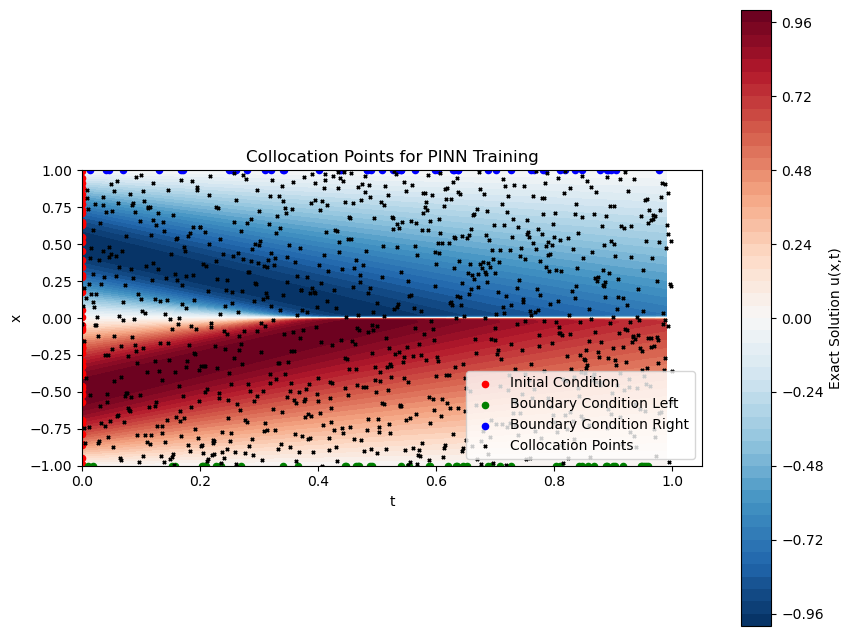

In [50]:
from src.viz import visualize_collocation_points
visualize_collocation_points(data)

In [51]:
# Train model
print("\nTraining PINN...")
loss_history_pinn = pinn_model.train_pinn(pinn_optimizer, data, nu, epochs, lambda_ic, lambda_bc, log_interval=1000)



Training PINN...
Epoch 1000/20000                       -- Total Loss: 0.146006                       -- PDE Loss: 0.051017                       -- IC Loss: 0.094765                       -- BC Loss: 0.000224
Epoch 2000/20000                       -- Total Loss: 0.013892                       -- PDE Loss: 0.006358                       -- IC Loss: 0.007467                       -- BC Loss: 0.000067
Epoch 3000/20000                       -- Total Loss: 0.007854                       -- PDE Loss: 0.004705                       -- IC Loss: 0.003088                       -- BC Loss: 0.000060
Epoch 4000/20000                       -- Total Loss: 0.004323                       -- PDE Loss: 0.002504                       -- IC Loss: 0.001783                       -- BC Loss: 0.000037
Epoch 5000/20000                       -- Total Loss: 0.000942                       -- PDE Loss: 0.000643                       -- IC Loss: 0.000280                       -- BC Loss: 0.000019
Epoch 6000/20000 

In [52]:
print("\nTraining SimpleNN...")
loss_history_simple = simple_model.train_nn(simple_optimizer, data, nu, epochs, lambda_ic, lambda_bc, log_interval=1000)


Training SimpleNN...
Epoch 1000/20000                       -- Total Loss: 0.002394                       -- Collocation Loss: 0.002235                       -- IC Loss: 0.000115                       -- BC Loss: 0.000044
Epoch 2000/20000                       -- Total Loss: 0.001160                       -- Collocation Loss: 0.000394                       -- IC Loss: 0.000166                       -- BC Loss: 0.000600
Epoch 3000/20000                       -- Total Loss: 0.000141                       -- Collocation Loss: 0.000119                       -- IC Loss: 0.000017                       -- BC Loss: 0.000005
Epoch 4000/20000                       -- Total Loss: 0.000176                       -- Collocation Loss: 0.000083                       -- IC Loss: 0.000037                       -- BC Loss: 0.000056
Epoch 5000/20000                       -- Total Loss: 0.000057                       -- Collocation Loss: 0.000045                       -- IC Loss: 0.000008                 

In [67]:
# Evaluate the solution
from src.train import evaluate_solution

# Evaluate solution
print("\nEvaluating PINN solution on grid...")
X_pinn, T_pinn, U_pinn = evaluate_solution(pinn_model, n_x=1000, n_t=1000)

# Evaluate solution
print("\nEvaluating Simple NN solution on grid...")
X_nn, T_nn, U_nn = evaluate_solution(simple_model, n_x=1000, n_t=1000)


Evaluating PINN solution on grid...

Evaluating Simple NN solution on grid...


In [68]:
# Check initial condition error
u_init_pred_pinn = U_pinn[0, :]
x_init_pinn = X_pinn[0, :]
u_init_exact_pinn = -np.sin(np.pi * x_init_pinn)
ic_error_pinn = np.mean(np.abs(u_init_pred_pinn - u_init_exact_pinn))
print(f"\nInitial condition mean absolute error: {ic_error_pinn:.6e}")

# Check boundary condition errors
bc_left_error_pinn = np.mean(np.abs(U_pinn[:, 0]))
bc_right_error_pinn = np.mean(np.abs(U_pinn[:, -1]))
print(f"Left boundary condition mean absolute error PINN: {bc_left_error_pinn:.6e}")
print(f"Right boundary condition mean absolute error PINN: {bc_right_error_pinn:.6e}")

# Check initial condition error
u_init_pred_nn = U_nn[0, :]
x_init_nn = X_nn[0, :]
u_init_exact_nn = -np.sin(np.pi * x_init_nn)
ic_error_nn = np.mean(np.abs(u_init_pred_nn - u_init_exact_nn))
print(f"\nInitial condition mean absolute error: {ic_error_nn:.6e}")

# Check boundary condition errors
bc_left_error_nn = np.mean(np.abs(U_nn[:, 0]))
bc_right_error_nn = np.mean(np.abs(U_nn[:, -1]))
print(f"Left boundary condition mean absolute error NN: {bc_left_error_nn:.6e}")
print(f"Right boundary condition mean absolute error NN: {bc_right_error_nn:.6e}")


Initial condition mean absolute error: 6.007599e-03
Left boundary condition mean absolute error PINN: 1.056962e-02
Right boundary condition mean absolute error PINN: 1.017766e-02

Initial condition mean absolute error: 1.591686e-03
Left boundary condition mean absolute error NN: 1.635176e-03
Right boundary condition mean absolute error NN: 1.213101e-03



Generating visualizations...


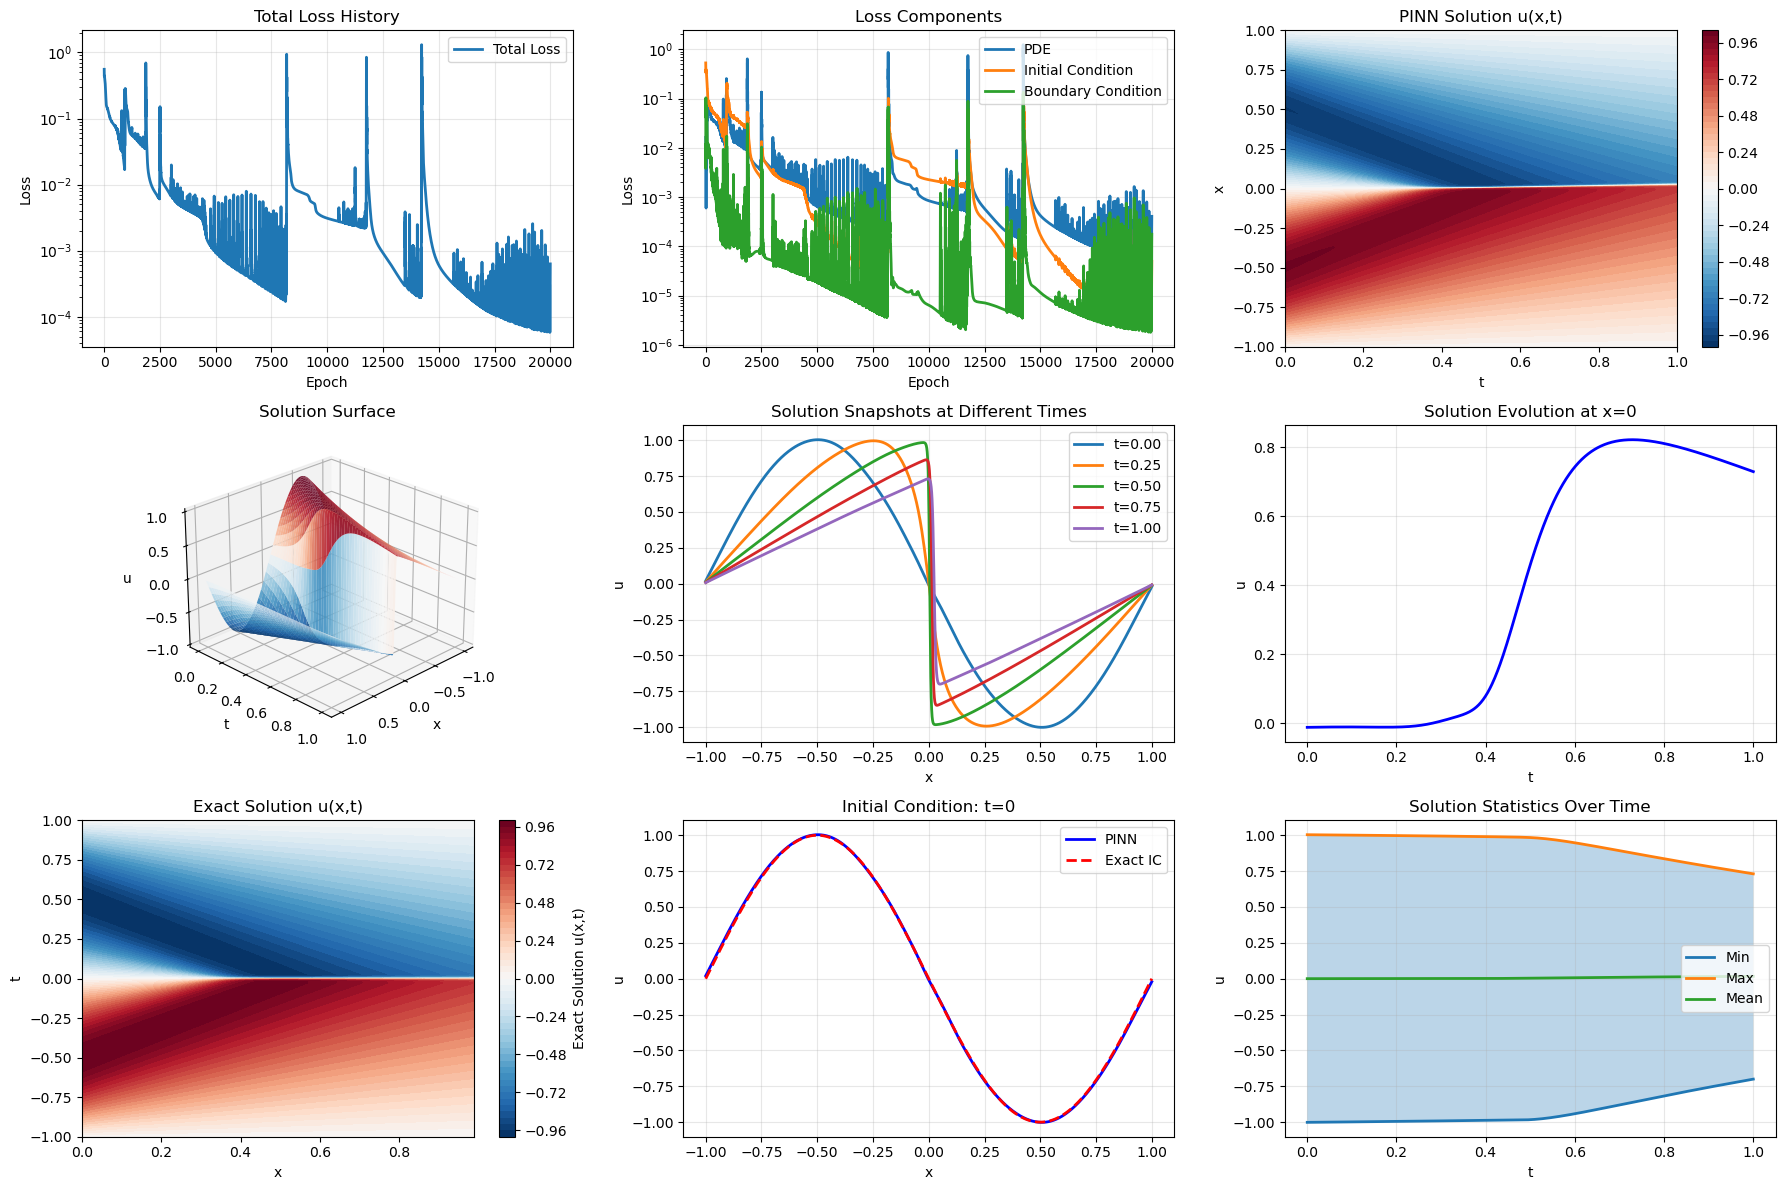

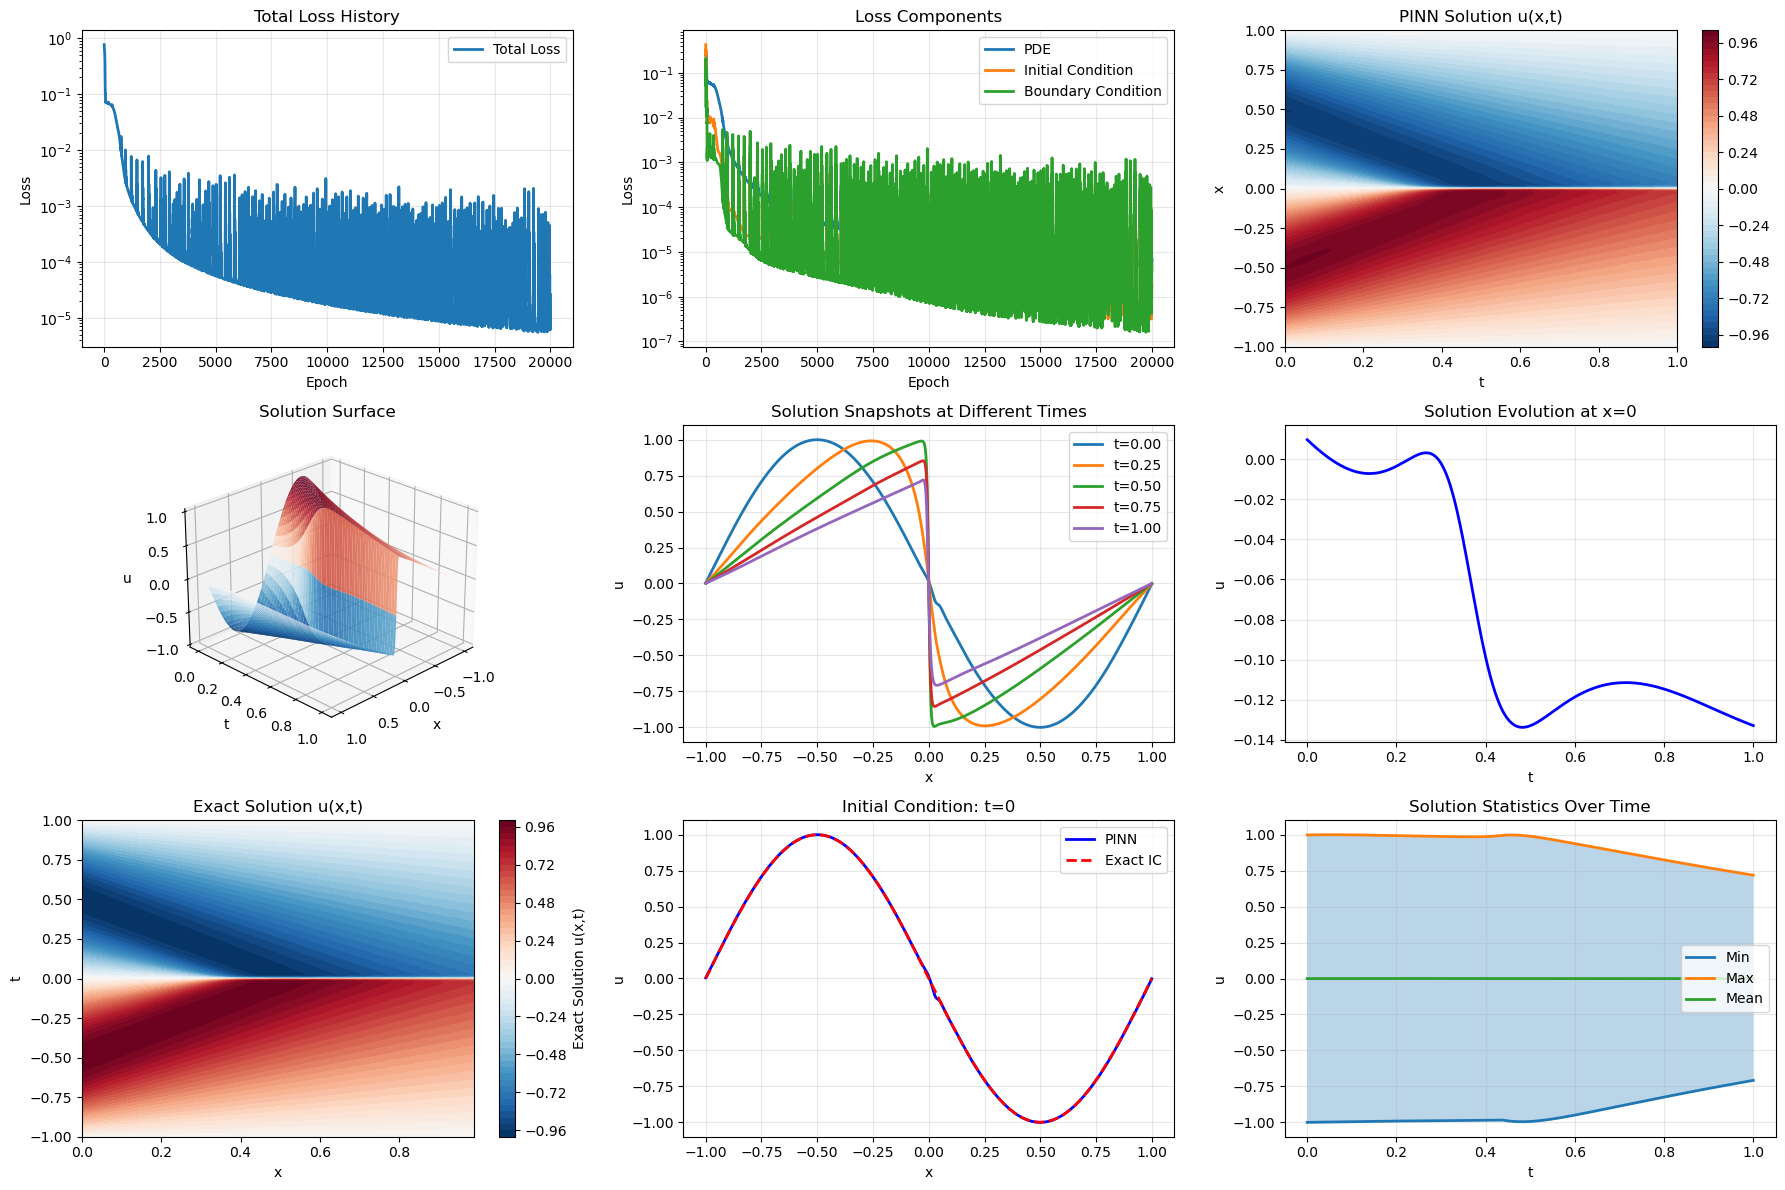


Training completed successfully!


In [69]:
# Visualize results
from src.viz import visualize_results
print("\nGenerating visualizations...")
visualize_results(
	X_pinn, T_pinn, U_pinn, loss_history_pinn, path="burgers_results_pinn.png"
)
visualize_results(
	X_nn, T_nn, U_nn, loss_history_simple, path="burgers_results_nn.png"
)
print("\nTraining completed successfully!")

In [70]:
# Approximation errors
from src.train import approximation_error
pinn_error = approximation_error(pinn_model)
nn_error = approximation_error(simple_model)

print("\nApproximation Errors:")
print(f"\nPINN L2 Error: {np.mean(pinn_error[0]):.6e}")
print(f"Simple NN Error: {np.mean(nn_error[0]):.6e}")
print(f"\nPINN L2 Relative Error: {pinn_error[1]:.6e}")
print(f"Simple NN L2 Relative Error: {nn_error[1]:.6e}")


Approximation Errors:

PINN L2 Error: 1.188273e-02
Simple NN Error: 2.294229e-03

PINN L2 Relative Error: 1.165383e-01
Simple NN L2 Relative Error: 1.097012e-02


In [71]:
from src.burger_eq import compute_pde_residual
(x_init, t_init, u_init,
        x_bc_left, t_bc_left, u_bc_left,
        x_bc_right, t_bc_right, u_bc_right,
        x_col, t_col, u_col) = data
pde_residual_pinn = compute_pde_residual(pinn_model,  x_col, t_col, nu)
pde_residual_nn = compute_pde_residual(simple_model, x_col, t_col,nu)

print(f"\nPINN PDE Residual Mean Absolute Error: {torch.mean(torch.abs(pde_residual_pinn)).item():.6e}")
print(f"NN PDE Residual Mean Absolute Error: {torch.mean(torch.abs(pde_residual_nn)).item():.6e}")


PINN PDE Residual Mean Absolute Error: 7.904928e-03
NN PDE Residual Mean Absolute Error: 5.526476e-02
